This notebook experiments with finetuning BART by leveraging the Blurr library from FastAI. It is based on code from the Blurr library's official documentation.

https://ohmeow.github.io/blurr/modeling-summarization/

##Import the necessary libraries

In [ ]:
!pip install ohmeow-blurr
!pip install nlp
!pip install pyarrow==0.16.0

     |████████████████████████████████| 778kB 20.1MB/s 
     |████████████████████████████████| 1.1MB 42.2MB/s 
     |████████████████████████████████| 194kB 41.3MB/s 
     |████████████████████████████████| 1.1MB 56.3MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 3.0MB 53.3MB/s 
     |████████████████████████████████| 17.2MB 201kB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=6bc6f6a7de9904efea42238360415d6a8211b84a52003374d0e24a044a48d6ad
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=cdd46745684eb31ee0a8284e781ec35631c37a11571cd5b27f8f3f06fc76f431
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses
  Found existing installation: pyarrow 0.1

     |████████████████████████████████| 63.2MB 45kB/s 
  Found existing installation: pyarrow 1.0.0
    Uninstalling pyarrow-1.0.0:
      Successfully uninstalled pyarrow-1.0.0


In [ ]:
import nlp
import pandas as pd
from fastai2.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

##Data Preparation

The dataset is hosted on my google cloud bucket.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
project_id = 'test-281700'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

gs://spotify_asr_dataset/
gs://staging.test-281700.appspot.com/
gs://test-281700.appspot.com/


In [ ]:
bucket_name = 'spotify_asr_dataset'
#download dataset
!gsutil -m cp -r gs://{bucket_name}/dataset.csv /content/
#download metadata for episodes
!gsutil -m cp -r gs://{bucket_name}/metadata.tsv /content/

Copying gs://spotify_asr_dataset/dataset.csv...
/ [1/1 files][  2.9 GiB/  2.9 GiB] 100% Done  15.9 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.9 GiB.                                      
Copying gs://spotify_asr_dataset/metadata.tsv...
- [1/1 files][112.2 MiB/112.2 MiB] 100% Done                                    
Operation completed over 1 objects/112.2 MiB.                                    


In [ ]:
dataset = pd.read_csv('dataset.csv')
podcasts_metadata = pd.read_csv('metadata.tsv', sep='\t')

In [ ]:
full_dataset = pd.merge(left=podcasts_metadata, right=dataset, how='left', left_on='episode_uri', right_on='episode_id')
del full_dataset['episode_uri']

In [ ]:
#filter contains the episodes that are officially recommended for training
filter = pd.read_csv('filtered-episode-ids.txt', sep=" ", header=None, names=["episode_id"])
filter.head()

,episode_id
0,spotify:episode:000A9sRBYdVh66csG2qEdj
1,spotify:episode:001UfOruzkA3Bn1SPjcdfa
2,spotify:episode:001i89SvIQgDuuyC53hfBm
3,spotify:episode:0025RWNwe2lnp6HcnfzwzG
4,spotify:episode:002NDlaaJN4vUczXHDHqWZ


In [ ]:
train_data = full_dataset.loc[full_dataset["episode_id"].isin(filter['episode_id'])]

In [ ]:
#Training is done on a subset of the data until the full train set is exhausted
train_data = train_data[['episode_id', 'transcript', 'episode_description']][:5000] #struggling to run with the full 65k

In [ ]:
train_data.head()

,episode_id,transcript,episode_description
0,spotify:episode:000A9sRBYdVh66csG2qEdj,"Hello. Hello. Hello everyone. This is Katie and we are here together on our first ever episode of cream in your coffee. Thank you so much guys for humoring me on this podcast Journey. It's been a huge goal of mine for the past few years. I finally just growing a pair and jumping right into it and seeing how it goes. So, thank you again for bearing with me here. Alrighty guys, so I figured for the first episode why not jump into a topic that is so exciting for pretty much everybody out there just around the corner and seven or eight days. We have the wonderful Christmas and I'm so excited...","On the first ever episode of Kream in your Koffee, Katie talks about tips for Christmas shopping. We also get a little insight into who and what we’ll be hearing about in next weeks episode!"
2,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Welcome to inside the 18. Today's episode is the sit down from the United Soccer Coaches convention with former US Men's National Team and former u.s. Women's National Team goalkeeper coach Phil weddin filled discusses how he started the international goalkeeper coaches conference what the US needs to do in order to create a successful goalkeeping curriculum across the entire United States and he gives his best advice to Young goalkeepers and goalkeeper coaches for me. This is by far one of my favorite episodes from the convention and I'm super excited for you guys to hear it. Make sure t...,"Today’s episode is a sit down Michael and Omar had with former USMNT and former USWNT goalkeeper coach, Phil Wheddon. Phil discusses how he started the International Goalkeeper Coaches Conference (IGCC), what the US needs to do in order to create a successful goalkeeping curriculum across the United States and lastly, he gives his best advice to young goalkeepers and goalkeeper coaches. Make sure to Subscribe to Inside the 18 on both Apple Podcasts and Spotify and don’t forget to leave us a rating and a comment to let us know how we’re doing! Contact Information: @la_goalkeeping_academy ..."
3,spotify:episode:001i89SvIQgDuuyC53hfBm,Hey cheese fans before we get started. I wanted to take a moment to talk about why we chose reproduce our podcasts on anchor. If you haven't heard about anchor it's by far the easiest way to make a podcast. Let me explain first and foremost it's free. They also offer creation tools that allow you to record and edit your podcast right from your phone or computer. Anchor will also distribute your podcast for you. So it can be heard on Spotify Apple podcast and many more platforms. You can make money from your podcast as well with no minimum listenership. It's everything you need to make a C...,"Join us as we take a look at all current Chiefs news, including the draft, free agency, in-house contract talks, and much more! --- This episode is sponsored by · Anchor: The easiest way to make a podcast. https://anchor.fm/app"
4,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"Sorry to interrupt the show, but I do have to bring you a really quick word from our sponsor. Anchor FM. I host fuckboys of lid on anchor and honestly, I love it. Anchor is the absolute easiest way to make a podcast. Let me explain first of all, it's free so you can't get any better than that. There's creation tools that allow you to record and edit your podcast right from your phone or computer anchor will distribute your podcast for you. So it can be heard on Spotify Apple podcasts and many other platforms. You can make money from your podcast with no minimum listenership, which is fant...","The modern morality tail of how to stay good for Christmas. Ashley Beall of Make It Modern Podcast (@MIM_Podcast) joins me to discuss the redemption arcs of one of KidLit's biggest fuckbois, Edmund Pevensie. iTunes Spotify YouTube Stitcher Google Play Music Anchor Do you want to work with us? Email us! --- This episode is sponsored by · Anchor: The easiest way to make

In [ ]:
len(train_data)

5000

#Model Training

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

In [ ]:
hf_batch_tfm = HF_TextGenerationBatchTransform(hf_arch, hf_tokenizer)

blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=150)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('transcript'), 
                   get_y=ColReader('episode_description'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(train_data, bs=4) #32 is optimal but run out of ram, try 256 some other time

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([4, 512]), torch.Size([4, 150]))

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"Everybody and welcome into the Cyclone scoop. I'm Alex Halsted 24/7 Sports and Cyclone orders.com. I'm coming to you here at the start of the recruiting Dead period which is going to run through July 25th. And for the Dead period means is that kids can't visit campuses. Coaches can't go out to visit kids but it's not truly dead commitment. You're still going to happen coaches can still text and call recruits are so there's still some action but the recruiting Dead period that goes for a month from June 24th through July 24th. Does Give a Little Bit Of A Down Time and Time perfectly timed for the Cyclone scoop because I can take a little break take a breather and look back at what is it has in this 2020 recruiting class so far and what they still have to do by the time National side. And a rolls around in December and then I guess the final signing day even in February and so this is the perfect time for me to talk at you and tell you what I would say it has what they still need and I'm going to get a little bit of help later on in this episode with 24/7 Sports Midwest recruiting analyst Alan true. I'm going to bring him out and he's gonna help me break on a break down the flurry of commitments at Iowa State just had and what he thinks about some of these guys and I was States recruiting classes. They head into July, but before we get to Allen aye I'd want to kind of go through what I was to 2020 recruiting class looks like as we go into this Dead period Iowa State now has 13 commitment to the 2020 recruiting class when all is said and done my projection over at Cyclone alert.com is between 20 and 22 in this class. And so when you look at 13 against that number there about two-thirds of the way through this 2020 recruiting class. So what do they have right now? Well with seven commitments in the month of June, that's how they get to that 13 they went from Six commitments entering June to now 13 exiting June or probably exiting June. I'm here talking to you on the final days of June, but hey recruiting is fluid and Rican commitments can happen at any point. So if you're listening and that number changes, that's why but with those 13 commits right now Iowa state has eight players on the offensive side of the ball. They've really set a good foundation on the offensive side of the ball in this class. Not","Iowa State added seven commitments during June to bring its 2020 recruiting class to 13, including 10 prospects from the Midwest. As the dead period gets underway, The Cyclone Scoop looks at Iowa State's 2020 class as it stands now and is joined by 247Sports Midwest Recruiting analyst Allen Trieu, who helps break down some of Iowa State's recent additions while also taking a wholistic view of the efforts so far. You can see Iowa State's 2020 class here. Learn more about your ad choices. Visit megaphone.fm/adchoices"
1,"Welcome ladies and gentlemen, today's Pride lands podcast episode 2 today. We will be discussing the book study change the culture change. The game was superintendent. Dr. Diana Barrera who got a school board president Demetrio Garcia and staff and Community member, Donna Kelley. We are heroes. Hello, dr. Logan. ER the doctor is in the how are you doing today, ma'am? Well, I'm a little under the weather. So if I sound like I have a frog in my throat, it's because I do well edit that will add some helium to your voice. Thank you. Today is one of the books study Community book study sessions. Were we are basically going over the book you adopted for the school year change the culture change the game, correct? Yes. So what are these books study? Until like what is the the main purpose of of having these on you know weekend evening where we invite the community? Well, it started as an extension of the book says we were having with our leadership team. We began with the Leadership Summit in August with our district and campus staff leadership, and we needed something to Anchor us as a team or the year of

In [ ]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4}

In [ ]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_TextGenModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[model_cb],
                splitter=partial(text_gen_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(4.0655, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([4, 149, 50264]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 4, torch.Size([4, 512]), 4, torch.Size([4, 150]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=0.00015848931798245758)

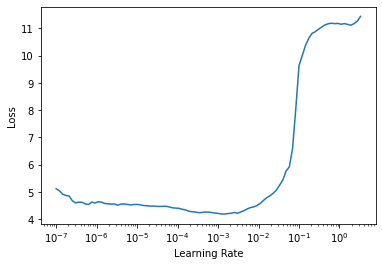

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(3, lr_max=3e-5) #can changr this too

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,2.982847,2.874946,0.268408,0.101879,0.198226,23:59
1,2.645571,2.781641,0.276447,0.107345,0.205283,24:18
2,2.503782,2.777961,0.273868,0.106768,0.202486,24:52


#Inference

In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French license plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
res = learn.blurr_predict(test_article)
print(res[0][:20])

 10 10. 10 men armed


In [ ]:
test_input_ids = dls.train_ds[0][0]['input_ids'].unsqueeze(0).to(learn.model.hf_model.device)
gen_text = learn.model.hf_model.generate(test_input_ids, num_beams=4, max_length=130, min_length=30)

print('=== Target ===')
print(f'{hf_tokenizer.decode(dls.train_ds[0][1]["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=False)}\n')

print('=== Prediction ===')
print(hf_tokenizer.decode(gen_text[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))


=== Target ===
 Iowa State added seven commitments during June to bring its 2020 recruiting class to 13, including 10 prospects from the Midwest. As the dead period gets underway, The Cyclone Scoop looks at Iowa State's 2020 class as it stands now and is joined by 247Sports Midwest Recruiting analyst Allen Trieu, who helps break down some of Iowa State's recent additions while also taking a wholistic view of the efforts so far. You can see Iowa State's 2020 class here. Learn more about your ad choices. Visit megaphone.fm/adchoices

=== Prediction ===
 In this episode I talk about Iowa State’s 2020 recruiting class and what they still have to do by the time National Signing Day rolls around in December.   ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app 


In [ ]:
outputs = learn.generate_text(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 About 10 men armed with pistols and machine guns raid a casino in Switzerland. They make off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say.

=== Prediction 2 ===
 About 10 men armed with pistols and machine guns raid a casino in Switzerland. They make off with several hundred thousand Swiss francs in the early hours of Sunday morning.

=== Prediction 3 ===
 About 10 men armed with pistols and machine guns raid a casino in Switzerland. They make off with several hundred thousand Swiss francs in the early hours of Sunday, police say.



#Save Model to use later

In [ ]:
learn.show_results(learner=learn)

NameError: ignored

In [ ]:
learn.export(fname='BART_finetuned_5000.pkl')

In [ ]:
inf_learn = load_learner(fname='BART_finetuned_5000.pkl')
inf_learn.generate_text(test_article)

[' About 10 men armed with pistols and machine guns raid a casino in Switzerland. They make off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say.']

In [1]:
bucket_name = 'spotify_asr_dataset'
#copy model to GCP
!gsutil -m cp -r /content/BART_finetuned_5000.pkl gs://{bucket_name}/

CommandException: No URLs matched: /content/BART_finetuned_5000.pkl
CommandException: 1 file/object could not be transferred.
